In [1]:
#importing the dataset using load_dataset
from datasets import load_dataset

import numpy as np

dataset = load_dataset(
    "tner/bionlp2004", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Found cached dataset bionlp2004 (/Users/thomascourts/Desktop/IDACoursework/./data_cache/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 16619
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3856
    })
})


In [2]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [3]:
print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')
print(f'Number of test sentences = {len(test_sentences_ner)}')

Number of training sentences = 16619
Number of validation sentences = 1927
Number of test sentences = 3856


In [4]:
print(f'What does one instance look like from the training set? \n\n{train_sentences_ner[234]}')
print(f'...and here is its corresponding label \n\n{train_labels_ner[234]}')

What does one instance look like from the training set? 

['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.']
...and here is its corresponding label 

['0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3', '4', '0']


In [5]:
print(f'Number of unique labels: {np.unique(np.concatenate(train_labels_ner))}')

Number of unique labels: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


In [6]:
#mapping from labels to the tags

id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}


In [7]:
#creating a function for my selected features
def token2features(sent, i):
    word = sent[i]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


In [8]:
def sent2features(sent):
    return [token2features(sent, i) for i in range(len(sent))]

def extract_features(sents):
    return [sent2features(sent) for sent in sents]


In [9]:
#using the extracted features function on the training, validation and test datasets 
X_train = extract_features(train_sentences_ner)
X_val = extract_features(val_sentences_ner)
X_test = extract_features(test_sentences_ner)


In [11]:
print(len(X_train))
print(len(val_labels_ner))



16619
1927


In [12]:
#importing libraries used for calculating performance metrics
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report
from itertools import chain

#fitting the CRF model on the training dataset
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, train_labels_ner)




#predicting on the validation set and creating a classification report of the results
y_pred = crf.predict(X_val)
y_true_flat = list(chain.from_iterable(val_labels_ner))
y_pred_flat = list(chain.from_iterable(y_pred))
print(classification_report(y_true_flat, y_pred_flat))





              precision    recall  f1-score   support

           0       0.96      0.97      0.96     38603
           1       0.77      0.64      0.70      1260
          10       0.76      0.65      0.70       189
           2       0.77      0.74      0.75      2100
           3       0.83      0.80      0.82      3029
           4       0.81      0.81      0.81      2743
           5       0.77      0.75      0.76       628
           6       0.74      0.78      0.76       696
           7       0.81      0.65      0.72       505
           8       0.83      0.74      0.78       940
           9       0.73      0.62      0.67       131

    accuracy                           0.92     50824
   macro avg       0.80      0.74      0.77     50824
weighted avg       0.92      0.92      0.92     50824



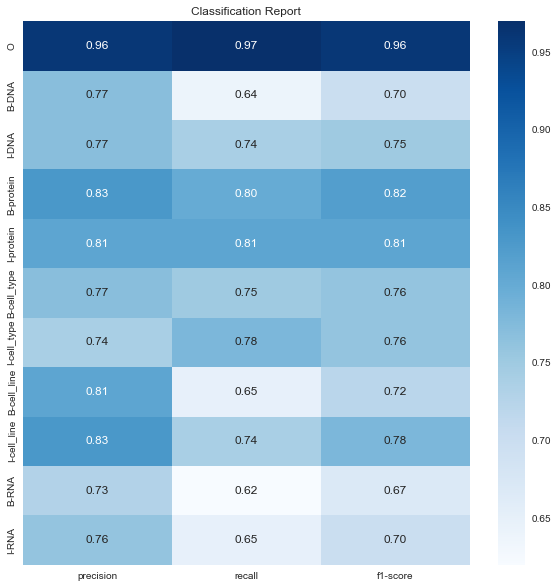

In [47]:
#importing libraries that are relevant to showing my results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#creating a dictionary for my classification report results in order to be able to plot graphs
report = {
    'O': {'precision': 0.96, 'recall': 0.97, 'f1-score': 0.96, 'support': 38603},
    'B-DNA': {'precision': 0.77, 'recall': 0.64, 'f1-score': 0.70, 'support': 1260},
    'I-DNA': {'precision': 0.77, 'recall': 0.74, 'f1-score': 0.75, 'support': 2100},
    'B-protein': {'precision': 0.83, 'recall': 0.80, 'f1-score': 0.82, 'support': 3029},
    'I-protein': {'precision': 0.81, 'recall': 0.81, 'f1-score': 0.81, 'support': 2743},
    'B-cell_type': {'precision': 0.77, 'recall': 0.75, 'f1-score': 0.76, 'support': 628},
    'I-cell_type': {'precision': 0.74, 'recall': 0.78, 'f1-score': 0.76, 'support': 696},
    'B-cell_line': {'precision': 0.81, 'recall': 0.65, 'f1-score': 0.72, 'support': 505},
    'I-cell_line': {'precision': 0.83, 'recall': 0.74, 'f1-score': 0.78, 'support': 940},
    'B-RNA': {'precision': 0.73, 'recall': 0.62, 'f1-score': 0.67, 'support': 131},
    'I-RNA': {'precision': 0.76, 'recall': 0.65, 'f1-score': 0.70, 'support': 189}
}



#converting the classification report into a DataFrame
report_df = pd.DataFrame(report).transpose()

#dropping the support column
report_df = report_df.drop('support', axis=1)

#plotting a the classification report results as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues')
plt.title("Classification Report")
plt.show()


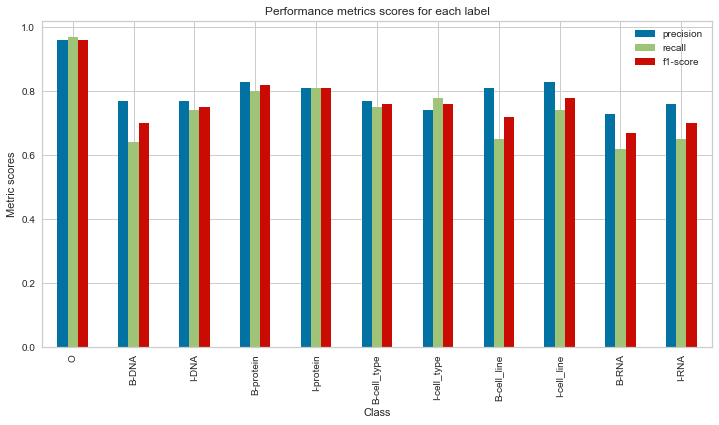

In [41]:
#creating a bar chart that plots the metric scores for each class
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12,6))
plt.title('Performance metrics scores for each label')
plt.xlabel('Class')
plt.ylabel('Metric scores')
plt.show()

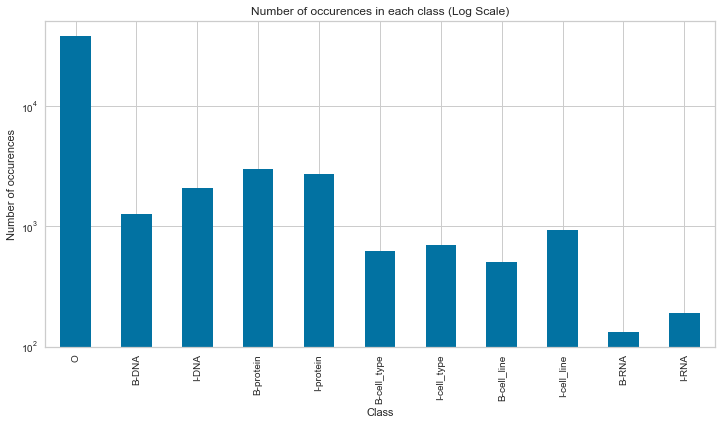

In [43]:
#creating a bar chart for the number of occurences for each class based on the support in classification report
report_df_supp = pd.DataFrame(report).transpose()
#logarithmically scaling the bar chart due to 0 having significantly more occurences
report_df_supp['support'].plot(kind='bar', logy=True, figsize=(12,6))
plt.title('Number of occurences in each class (Log Scale)')
plt.ylabel('Number of occurences')
plt.xlabel('Class')
plt.show()
